In [63]:
import os
import h5py
import re
import pylab as pl
import numpy as np
from libtiff import TIFF
from skimage.measure import block_reduce
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import generic_filter as gf


In [50]:
%matplotlib inline

In [51]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

frame0.tiff
(164, 218)


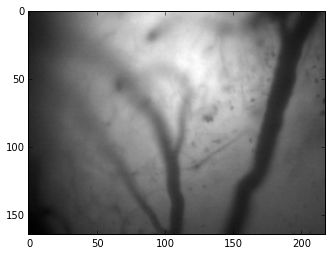

In [16]:
# Surface image:
if 'surface' in os.listdir(acquisition_dir):
    surface_dir = os.path.join(acquisition_dir, 'surface')
elif 'Surface' in os.listdir(acquisition_dir):
    surface_dir = os.path.join(acquisition_dir, 'Surface')
else:
    surface_dir = os.path.join(source, animal, 'surface') #, '*%s*.tif' % session)

surface_fn = [f for f in os.listdir(surface_dir) if f.endswith(img_fmt)][0]
print surface_fn
surface_impath = os.path.join(surface_dir, surface_fn)

surftiff = TIFF.open(surface_impath, mode='r')
surface = surftiff.read_image().astype('float')
surftiff.close()
pl.imshow(surface, cmap='gray')
print surface.shape

In [52]:
rootdir = '/nas/volume1/2photon/data'
animalid = 'JR066'
session = '20180105'
acquisition = 'LM_epi'
img_fmt = 'tiff'
acquisition_dir = os.path.join(rootdir, animalid, session, acquisition)


In [53]:
runs = [run for run in os.listdir(acquisition_dir) if os.path.isdir(os.path.join(acquisition_dir, run)) and 'surface' not in run and 'Surface' not in run]
print "RUNS:"
print runs


RUNS:
['JR066_bar_013Hz']


In [54]:
trials = dict()
for run in runs:
    trials[run] = [t for t in os.listdir(os.path.join(acquisition_dir, run)) if 'trial' in t]
    
print trials

el_trials = []
az_trials = []
for trial in trials[runs[0]]:
    if 'bottom' in trial:
        el_trials.append(trial)
    if 'right' in trial:
        az_trials.append(trial)

az_trials = sorted(az_trials, key=natural_keys)
el_trials = sorted(el_trials, key=natural_keys)
print "AZ:", az_trials
print "EL:", el_trials

{'JR066_bar_013Hz': ['trial006_bottom', 'trial002_bottom', 'trial004_bottom', 'trial008_bottom', 'trial007_right', 'trial005_right', 'trial001_right', 'trial003_right']}
AZ: ['trial001_right', 'trial003_right', 'trial005_right', 'trial007_right']
EL: ['trial002_bottom', 'trial004_bottom', 'trial006_bottom', 'trial008_bottom']


In [55]:
az_trial = 1
el_trial = 1


In [56]:
curr_az_trial = az_trials[az_trial]
curr_el_trial = el_trials[el_trial]

az_fft_fn = [f for f in os.listdir(os.path.join(acquisition_dir, run, curr_az_trial)) if f.endswith('hdf5')][0]
az_fft = h5py.File(os.path.join(acquisition_dir, run, curr_az_trial, az_fft_fn), 'r')

el_fft_fn = [f for f in os.listdir(os.path.join(acquisition_dir, run, curr_el_trial)) if f.endswith('hdf5')][0]
el_fft = h5py.File(os.path.join(acquisition_dir, run, curr_el_trial, el_fft_fn), 'r')


az_phasemap = np.array(az_fft['maps']['phase_target'])
az_ratiomap = np.array(az_fft['maps']['magnitude_ratios'])
el_phasemap = np.array(el_fft['maps']['phase_target'])
el_ratiomap = np.array(el_fft['maps']['magnitude_ratios'])

#az_fft.close()
#el_fft.close()

In [57]:
# Check dimensions:
if not az_phasemap.shape==surface.shape:
    reduce_val = surface.shape[0]/az_phasemap.shape[0]
    print reduce_val
    if reduce_val>1:
        surface = block_reduce(surface, (reduce_val, reduce_val), func=np.mean)
        print surface.shape
    elif reduce_val<1:
        reduce_val = 1./reduce_val
        az_phasemap = block_reduce(az_phasemap, (reduce_val, reduce_val), func=np.mean)
        el_phasemap = block_reduce(el_phasemap, (reduce_val, reduce_val), func=np.mean)
        az_ratiomap = block_reduce(az_ratiomap, (reduce_val, reduce_val), func=np.mean)
        el_ratiomap = block_reduce(el_ratiomap, (reduce_val, reduce_val), func=np.mean)

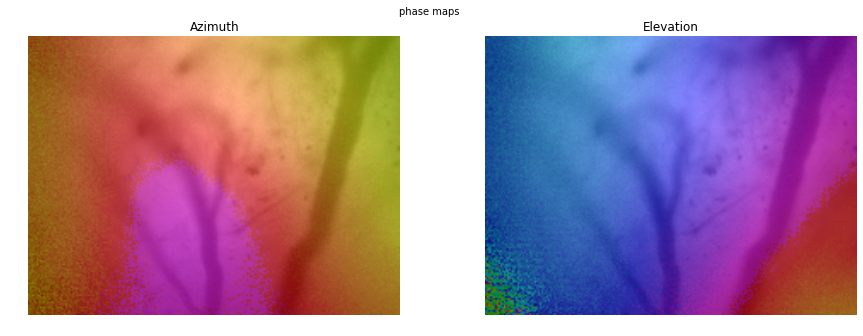

In [60]:
pl.figure(figsize=(15,5))
pl.subplot(1,2,1); pl.title('Azimuth')
pl.imshow(surface, cmap='gray'); pl.axis('off')
pl.imshow(az_phasemap, alpha=0.5, cmap='gist_rainbow'); pl.axis('off')

pl.subplot(1,2,2); pl.title('Elevation')
pl.imshow(surface, cmap='gray'); pl.axis('off')
pl.imshow(el_phasemap, alpha=0.5, cmap='gist_rainbow'); pl.axis('off')
pl.suptitle('phase maps')

In [79]:
threshold = 0.2
min_thr = min([az_ratiomap.max(), el_ratiomap.max()]) * threshold # 0.003
print min_thr
print az_ratiomap.shape

0.00696457556702
(164, 218)


In [80]:
# Convert to continous range:

az_phase = -1 * az_phasemap
az_phase = az_phase % (2*np.pi)

el_phase = -1 * el_phasemap
el_phase = el_phase % (2*np.pi)

(-0.5, 217.5, 163.5, -0.5)

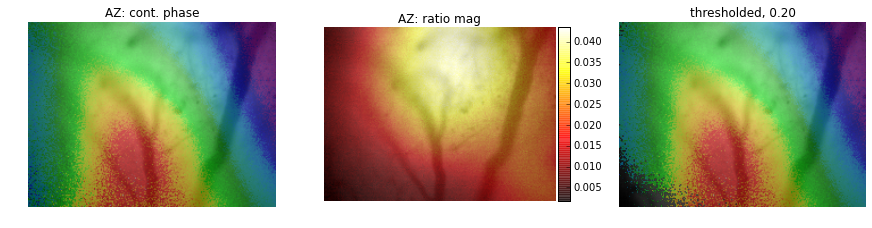

In [82]:

phasemin = 0
phasemax = 2*np.pi

pl.figure(figsize=(15,5))
pl.subplot(1,3,1); pl.title('AZ: cont. phase')
pl.imshow(surface, cmap='gray')
pl.imshow(az_phase, alpha=0.5, cmap='spectral'); pl.axis('off')

ax=pl.subplot(1,3,2); pl.title('AZ: ratio mag')
pl.imshow(surface, cmap='gray')
im=pl.imshow(az_ratiomap, alpha=0.5, cmap='hot'); pl.axis('off'); 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
pl.colorbar(im, cax=cax)

az_phasemap_thr = np.copy(az_phase)
az_phasemap_thr[az_ratiomap<=min_thr] = np.nan

pl.subplot(1,3,3); pl.title('thresholded, %.2f' % threshold)
pl.imshow(surface, cmap='gray')
pl.imshow(az_phasemap_thr,alpha=0.5,cmap='spectral'); pl.axis('off')

(-0.5, 217.5, 163.5, -0.5)

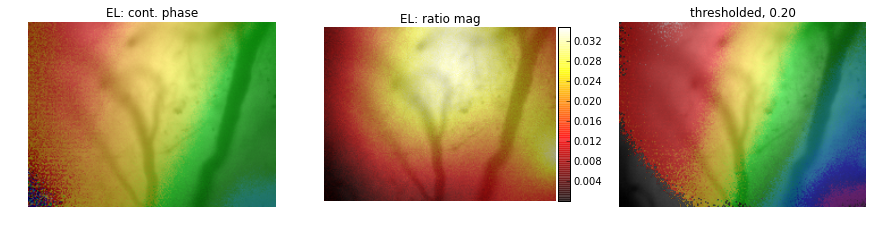

In [84]:

phasemin = 0
phasemax = 2*np.pi

pl.figure(figsize=(15,5))
pl.subplot(1,3,1); pl.title('EL: cont. phase')
pl.imshow(surface, cmap='gray')
pl.imshow(el_phase, alpha=0.5, cmap='spectral'); pl.axis('off')

ax=pl.subplot(1,3,2); pl.title('EL: ratio mag')
pl.imshow(surface, cmap='gray')
im=pl.imshow(el_ratiomap, alpha=0.5, cmap='hot'); pl.axis('off'); 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
pl.colorbar(im, cax=cax)

el_phasemap_thr = np.copy(el_phase)
el_phasemap_thr[el_ratiomap<=min_thr] = np.nan

pl.subplot(1,3,3); pl.title('thresholded, %.2f' % threshold)
pl.imshow(surface, cmap='gray')
pl.imshow(el_phasemap_thr,alpha=0.5,cmap='spectral'); pl.axis('off')

In [86]:
# Low-pass filter phase map w/ uniform circular kernel:

radius = 2
kernel = np.zeros((2*radius+1, 2*radius+1))
y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
mask = x**2 + y**2 <= radius**2
kernel[mask] = 1

In [87]:
az_phasemap_filt = gf(az_phase, np.min, footprint=kernel)
el_phasemap_filt = gf(el_phase, np.min, footprint=kernel)

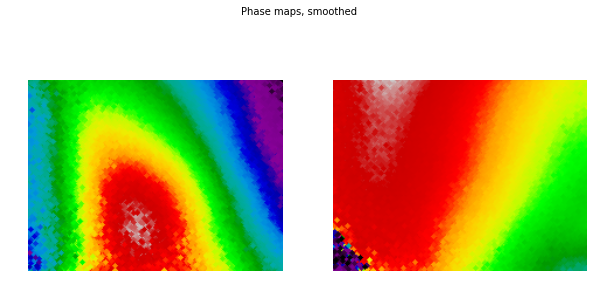

In [88]:
pl.figure(figsize=(10,5))
pl.subplot(1,2,1); pl.imshow(az_phasemap_filt, cmap='spectral'); pl.axis('off')
pl.subplot(1,2,2); pl.imshow(el_phasemap_filt, cmap='spectral'); pl.axis('off')
pl.suptitle('Phase maps, smoothed')

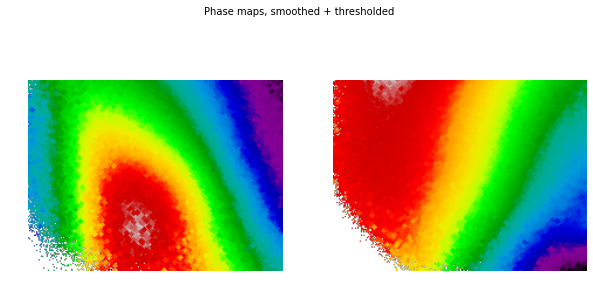

In [89]:
az_phasemap_thresh = np.copy(az_phasemap_filt)
az_phasemap_thresh[az_ratiomap<=min_thr] = np.nan

el_phasemap_thresh = np.copy(el_phasemap_filt)
el_phasemap_thresh[el_ratiomap<=min_thr] = np.nan

pl.figure(figsize=(10,5))
pl.subplot(1,2,1); pl.imshow(az_phasemap_thresh, cmap='spectral'); pl.axis('off')
pl.subplot(1,2,2); pl.imshow(el_phasemap_thresh, cmap='spectral'); pl.axis('off')
pl.suptitle('Phase maps, smoothed + thresholded')

### Convert to CM, draw iso-contours on monitor:


In [92]:
width = 102.87
height = 57.86
resolution = [1920, 1080]


In [93]:
C2A_cm = width/2.
C2T_cm = height/2.
C2P_cm = width/2.
C2B_cm = height/2.
print "center 2 Top/Anterior:", C2T_cm, C2A_cm

center 2 Top/Anterior: 28.93 51.435


In [94]:
mapx = np.linspace(-1*C2A_cm, C2P_cm, resolution[0])
mapy = np.linspace(C2T_cm, -1*C2B_cm, resolution[1])

lin_coord_x, lin_coord_y = np.meshgrid(mapx, mapy, sparse=False)

In [95]:
mapcorX, mapcorY = np.meshgrid(range(resolution[0]), range(resolution[1]))

In [96]:
interval = 10
short_axis = False

(-0.5, 1919.5, 1079.5, -0.5)

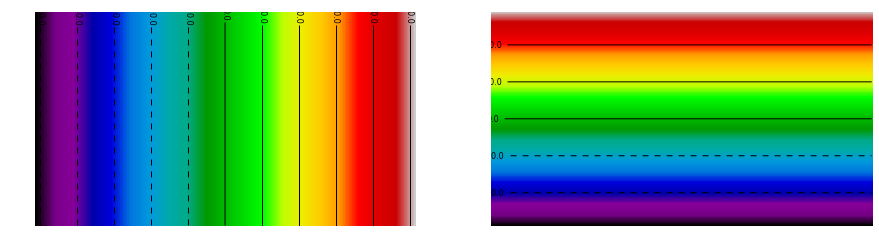

In [131]:
linminW = lin_coord_x.min()
linmaxW = lin_coord_x.max()

linminH = lin_coord_y.min()
linmaxH = lin_coord_y.max()

cmap='spectral'

f1 = pl.figure(figsize=(15,5))

pl.subplot(1,2,1)

currfig = pl.imshow(lin_coord_x, vmin=linminW, vmax=linmaxW,  cmap=cmap)
levels1 = range(int(np.floor(lin_coord_x.min() / interval) * interval), 
                int((np.ceil(lin_coord_x.max() / interval) + 1) * interval), interval)


im1 = pl.contour(mapcorX, mapcorY, lin_coord_x, levels1, colors='k', linewidth=2)
pl.clabel(im1, levels1, fontsize=8, inline=3, fmt='%1.1f') #, inline_spacing=2, manual=label_pos)
#f1.colorbar(currfig, ticks=levels1)
pl.axis('off')

pl.subplot(1,2,2)
if short_axis is False:
    curr_fig = pl.imshow(lin_coord_y, vmin=linminH, vmax=linmaxH, cmap=cmap) #pl.colorbar()
else:
    curr_fig = pl.imshow(lin_coord_y, vmin=linminW, vmax=linmaxW, cmap=cmap) #pl.colorbar()

levels2 = range(int(np.floor(lin_coord_y.min() / interval) * interval), 
                int((np.ceil(lin_coord_y.max() / interval) + 1) * interval), interval)

im2 = pl.contour(mapcorX, mapcorY, lin_coord_y, levels2, colors='k', linewidth=2)
pl.clabel(im2, levels2, fontsize=8, inline=3, fmt='%1.1f') #, inline_spacing=2, manual=label_pos)
pl.axis('off')

### PLOT CONTOUR MAPS:

In [123]:
imsize = az_phasemap_thresh.shape
print imsize

(164, 218)


In [124]:
def convert_values(oldval, newmin, newmax, oldmax=phasemax, oldmin=phasemin):
    oldrange = (oldmax - oldmin)  
    newrange = (newmax - newmin)  
    newval = (((oldval - oldmin) * newrange) / oldrange) + newmin
    return newval


In [125]:
az_phasemap_lincoord = np.copy(az_phasemap_thresh)
el_phasemap_lincoord = np.copy(el_phasemap_thresh)

for x in range(az_phasemap_thresh.shape[0]):
    for y in range(az_phasemap_thresh.shape[1]):
        if not np.isnan(az_phasemap_thresh[x,y]):
            az_phasemap_lincoord[x,y] = convert_values(az_phasemap_thresh[x,y], linminW, linmaxW)
            if short_axis is True:
                el_phasemap_lincoord[x,y] = convert_values(el_phasemap_thresh[x,y], linminH, linmaxH)
            else:
                el_phasemap_lincoord[x,y] = convert_values(el_phasemap_thresh[x,y], linminW, linmaxW)
                
        

#### Set contour params:

In [126]:
linmin = lin_coord_x.min()
linmax = lin_coord_x.max()
cmap='gist_rainbow'
fontsize = 32
linecolor = 'w'
linewidth = 60

import matplotlib.gridspec as gridspec

#### Plot AZ contours:

AZ limits: [-27.60, 4.43]


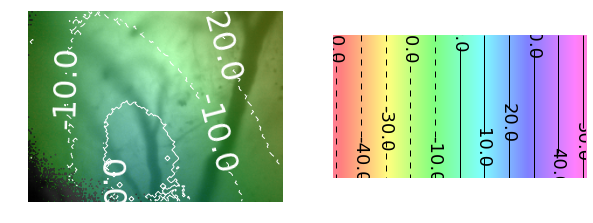

In [127]:
imgX, imgY = np.meshgrid(range(imsize[1]), range(imsize[0]))

pl.figure(figsize=(10,5))
pl.subplot(1,2,1)
pl.imshow(surface, cmap='gray')
currfig = pl.imshow(az_phasemap_thr, vmin=phasemin, vmax=phasemax,  cmap=cmap, alpha=0.3)
levels1 = range(int(np.floor(lin_coord_x.min() / interval) * interval), 
                int((np.ceil(lin_coord_x.max() / interval) + 1) * interval), interval)
im1 = pl.contour(imgX, imgY, az_phasemap_lincoord, levels1, colors='w', linewidth=linewidth)
pl.clabel(im1, levels1, fontsize=fontsize, inline=3, fmt='%1.1f') #, inline_spacing=2, manual=label_pos)
pl.axis('off')

pl.subplot(1,2,2)
currfig = pl.imshow(lin_coord_x, vmin=linminW, vmax=linmaxW,cmap=cmap, alpha=0.5)
levels1 = range(int(np.floor(lin_coord_x.min() / interval) * interval), 
                int((np.ceil(lin_coord_x.max() / interval) + 1) * interval), interval)
im1 = pl.contour(mapcorX, mapcorY, lin_coord_x, levels1, colors='k', linewidth=2)
pl.clabel(im1, levels1, fontsize=18, inline=3, fmt='%1.1f', inline_spacing=2) #, manual=label_pos)
pl.axis('off')

az_linear_min = np.nanmin(az_phasemap_lincoord)
az_linear_max = np.nanmax(az_phasemap_lincoord)
print "AZ limits: [%.2f, %.2f]" % (az_linear_min, az_linear_max)

### Plot EL contours

EL limits: [-15.98, 36.47]


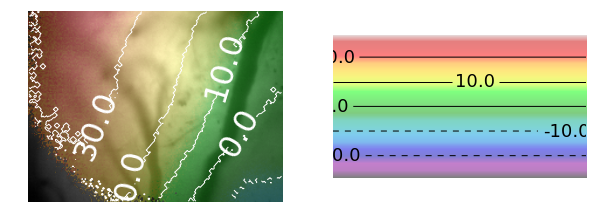

In [135]:
imgX, imgY = np.meshgrid(range(imsize[1]), range(imsize[0]))

pl.figure(figsize=(10,5))

pl.subplot(1,2,1)
pl.imshow(surface, cmap='gray')
currfig = pl.imshow(el_phasemap_thr, vmin=phasemin, vmax=phasemax,  cmap=cmap, alpha=0.3)
levels2 = range(int(np.floor(lin_coord_y.min() / interval) * interval), 
                int((np.ceil(lin_coord_y.max() / interval) + 1) * interval), interval)
im2 = pl.contour(imgX, imgY, el_phasemap_lincoord, levels2, colors='w', linewidth=linewidth)
pl.clabel(im2, levels2, fontsize=fontsize, inline=3, fmt='%1.1f') #, inline_spacing=2, manual=label_pos)
pl.axis('off')

pl.subplot(1,2,2)
if short_axis is False:
    curr_fig = pl.imshow(lin_coord_y, vmin=linminH, vmax=linmaxH, cmap=cmap, alpha=0.5) #pl.colorbar()
else:
    curr_fig = pl.imshow(lin_coord_y, vmin=linminW, vmax=linmaxW, cmap=cmap, alpha=0.5) #pl.colorbar()

levels2 = range(int(np.floor(lin_coord_y.min() / interval) * interval), 
                int((np.ceil(lin_coord_y.max() / interval) + 1) * interval), interval)

im2 = pl.contour(mapcorX, mapcorY, lin_coord_y, levels2, colors='k', linewidth=2)
pl.clabel(im2, levels2, fontsize=18, inline=3, fmt='%1.1f', inline_spacing=2) #, manual=label_pos)
pl.axis('off')

# Get limits
el_linear_min = np.nanmin(el_phasemap_lincoord)
el_linear_max = np.nanmax(el_phasemap_lincoord)
print "EL limits: [%.2f, %.2f]" % (el_linear_min, el_linear_max)

### Plot overlaid contour lines:

(-0.5, 217.5, 163.5, -0.5)

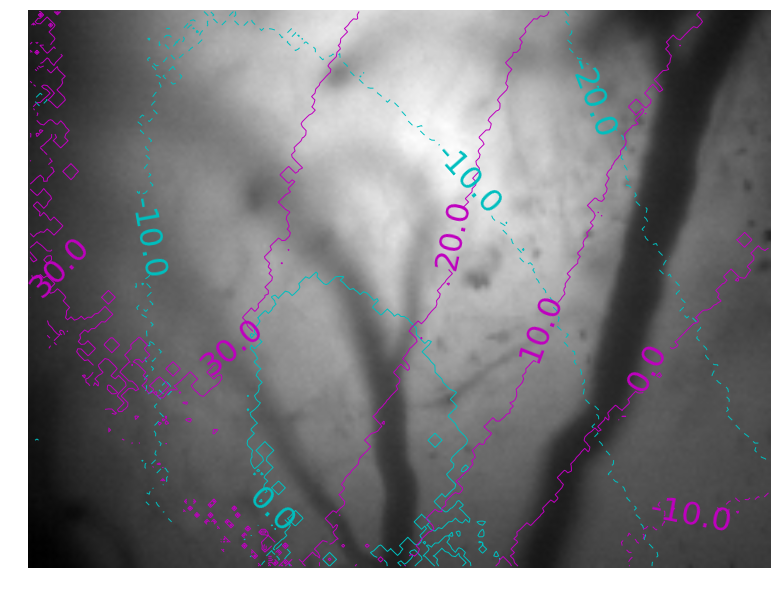

In [137]:
pl.figure(figsize=(15,10))

pl.imshow(surface, cmap='gray')

im1 = pl.contour(imgX, imgY, az_phasemap_lincoord, levels1, colors='c', linewidth=4)
pl.clabel(im1, levels1, fontsize=fontsize, inline=3, fmt='%1.1f') #, inline_spacing=2, manual=label_pos)

im2 = pl.contour(imgX, imgY, el_phasemap_lincoord, levels2, colors='m', linewidth=4)
pl.clabel(im2, levels2, fontsize=fontsize, inline=3, fmt='%1.1f') #, inline_spacing=2, manual=label_pos)
pl.axis('off')